<a href="https://colab.research.google.com/github/josh-fleegler/ME35/blob/main/Copy_of_RandomWalk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RandomWalk: Agent begins in the center of a one dimensional path and gets the most reward when it moves to the rightmost state

**Actions:** Move left or right

**Reward:** -1 when agent is at the leftmost and +1 when agent is at the rightmost state

**State
 Space:** Current state

**Think about parameters to change when training your agent:**

*   What happens when you increase the value of epsilon or decrease it?
*   What happens when you give reward of 1 for reaching rightmost state but reward of 0 for any other state? What does your agent learn to do?
* What is the difference between the two functions max_action() and chooseAction() in the Agent class?
*   What happens if you change the End states? What if you change where the agent begins?  
*   What if you limit the number of timesteps the agent can run?



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 19 states (not including the ending state)
NUM_STATES = 19
START = 9
END_0 = 0
END_1 = 20
ACTION_SPACE = ["left", "right"]

In [ ]:
"""
Environment class:

Methods to execute given action, returns observation (state) of agent and reward received after executing an action

"""
class RandomWalkEnvironment:
    def __init__(self, action_space, start=START, end=False):
      """
        Agent begins in center state
      """
      self.action_space = action_space
      self.state = start  # current state
      self.end = end

    def vis(self):
      """
        Visualize the agent moving
      """
      arr = np.zeros((2, 21))
      agent = self.state
      arr[0][0] = -1
      arr[1][0] = -1
      arr[0][20] = 1
      arr[1][20] = 1
      arr[0][agent] = 9
      arr[1][agent] = 9
      plt.matshow(arr)
      plt.show()

    def takeAction(self, action):
      """
      Action taken only if agent is not at the two end states

        Parameters:
          action: string "left" or "right"

        Returns: int of new state

      """
      new_state = self.state
      if not self.end:
          if action == "left":
              new_state = self.state - 1
          else:
              new_state = self.state + 1

          if new_state in [END_0, END_1]:
          #if new_state in [END_1]:
              self.end = True
      self.state = new_state
      return self.state

    def giveReward(self):
      """
        Reward of -1 received if agent is at leftmost state
        Reward of +1 received if agent is at rightmost state
        Otherwise, reward of 0 received
      """
      ### TO DO: EDIT REWARD GIVEN ###

      if self.state == END_0:
          return -1
      if self.state == END_1:
          return 1
      # other states
      return 0

    def reset(self):
      """
        Resets agent to center state
      """
      self.state = START
      self.end = False
      return self.state

In [ ]:
"""
Agent class keeps the Qtable and determines how to choose an action

"""
class Agent:
  def __init__(self, action_space, start=START, end=False, lr=0.1, gamma=0.95, epsilon=0.1, lam=0.9):
        self.action_space = action_space
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.rows = NUM_STATES+2
        self.cols = len(self.action_space)
        self.lam = lam
        # initialize q table
        self.Q_values = np.zeros((NUM_STATES+2, len(self.action_space)))
        # init e(s,a)
        self.E_values = np.zeros((NUM_STATES+2, len(self.action_space)))

  def max_action(self, state):
    """
      Returns maximum action
    """
    # chooses action with maximum q value
    action = self.action_space[np.argmax(self.Q_values[state])]
    return action

  def chooseAction(self, state):
    """
      Returns a random action with probability epsilon otherwise returns an e-greedy action
      returns str "right" or "left"

      Parameters:
        state: int of current state

    """
    random_num = np.random.random()
    if(random_num < self.epsilon):
      # random action chosen
      action = np.random.choice(self.action_space)
    else:
      # chooses action with maximum q value
      action = self.action_space[np.argmax(self.Q_values[state])]
    return action

  def update_eq(self, delta):
    # updates the qtable using eligibility traces
    for i in range(self.rows):
      for j in range(self.cols):
        self.Q_values[i][j] = self.Q_values[i][j] + self.lr * delta * self.E_values[i][j]
        self.E_values[i][j] = self.gamma * self.lam * self.E_values[i][j]

  def reset(self):
    # reset the eligibility trace table
    self.E_values = np.zeros((NUM_STATES+2, len(self.action_space)))


In [ ]:
def train_agent(agent, env, episodes=200, debug=True):
  """
    Runs agent for a certain number of episodes and keeps track of the reward received per episode and the number of timesteps taken until agent reached end state
  """
  total_timesteps = []
  total_rewards = []
  for e in range(episodes):
    agent.reset()
    state = env.reset()
    t = 0
    r = 0
    action = agent.chooseAction(state)

    ### TO DO: Limit the number of timesteps agent can run with a for loop ###
    while True:
      old_state = state
      state = env.takeAction(action)  # next state
      reward = env.giveReward()  # next state-reward
      action_prime = agent.chooseAction(state) # choose new action based on qtable

      # code below updates qtable based on reward and constants
      # delta calculation
      delta = reward + agent.gamma * agent.Q_values[state][agent.action_space.index(action_prime)] - agent.Q_values[old_state][agent.action_space.index(action)]
      # accumulating traces
      agent.E_values[old_state][agent.action_space.index(action)] = agent.E_values[old_state][agent.action_space.index(action)] + 1
      agent.update_eq(delta)

      action = action_prime
      t += 1
      r += reward
      if(env.end):
        break
    if(debug):
      print("EPISODE " + str(e) + " total timesteps is " + str(t) + " total reward is " + str(r))
    total_timesteps.append(t)
    total_rewards.append(r)
  return total_timesteps, total_rewards

In [ ]:
def test_agent(agent, env):
  print("NOW TESTING...")
  agent.reset()
  state = env.reset()
  # change epsilon to be 0 so that random action is not chosen
  t = 0
  r = 0
  action = agent.max_action(state)
  env.vis()
  while True:
    old_state = state
    state = env.takeAction(action)  # next state
    reward = env.giveReward()  # next state-reward
    env.vis()
    action_prime = agent.max_action(state)
    action = action_prime
    t += 1
    r += reward
    if(env.end):
      break
  print("TESTING " + "total timesteps is " + str(t) +  " total rewards is " + str(r))

In [ ]:
def plot(graph, label):
  plt.figure(figsize=[10, 6])
  xpoints = np.arange(0,len(graph))
  plt.plot(xpoints, graph)

  plt.title(label)
  plt.xlabel('Episodes')
  plt.ylabel(label)
  plt.legend()

EPISODE 0 total timesteps is 9 total reward is -1
EPISODE 1 total timesteps is 359 total reward is 1
EPISODE 2 total timesteps is 51 total reward is 1
EPISODE 3 total timesteps is 25 total reward is 1
EPISODE 4 total timesteps is 17 total reward is 1
EPISODE 5 total timesteps is 43 total reward is 1
EPISODE 6 total timesteps is 11 total reward is 1
EPISODE 7 total timesteps is 17 total reward is 1
EPISODE 8 total timesteps is 13 total reward is 1
EPISODE 9 total timesteps is 17 total reward is 1
EPISODE 10 total timesteps is 11 total reward is 1
EPISODE 11 total timesteps is 11 total reward is 1
EPISODE 12 total timesteps is 11 total reward is 1
EPISODE 13 total timesteps is 13 total reward is 1
EPISODE 14 total timesteps is 15 total reward is 1
EPISODE 15 total timesteps is 13 total reward is 1
EPISODE 16 total timesteps is 11 total reward is 1
EPISODE 17 total timesteps is 13 total reward is 1
EPISODE 18 total timesteps is 13 total reward is 1
EPISODE 19 total timesteps is 11 total r

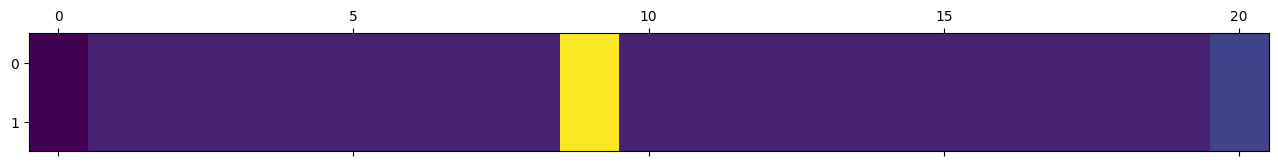

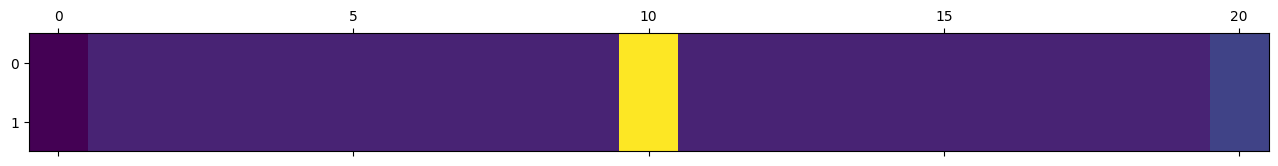

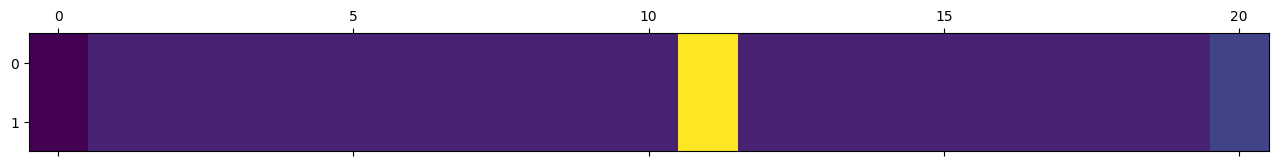

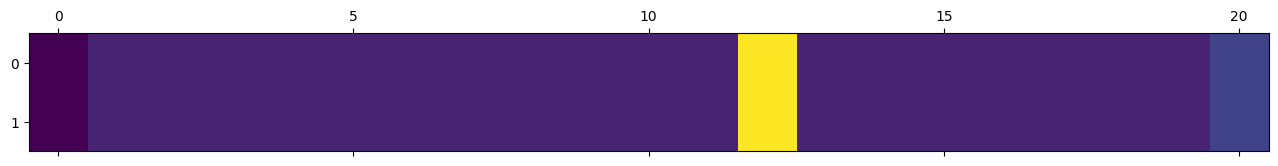

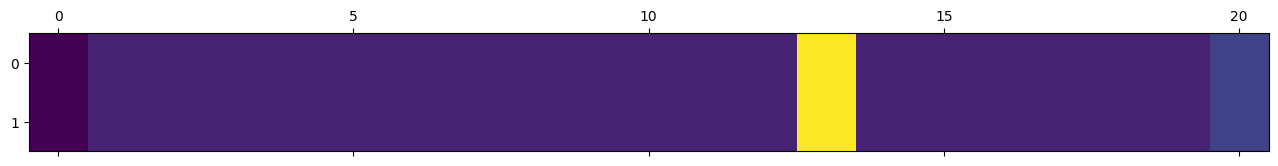

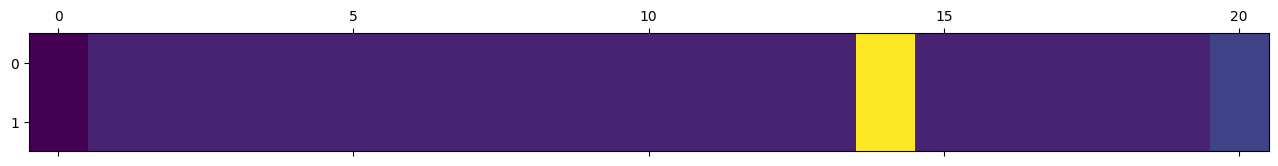

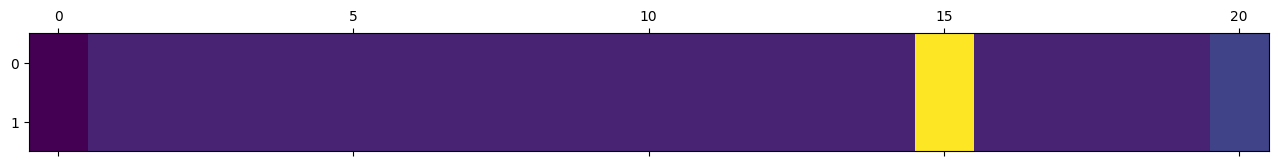

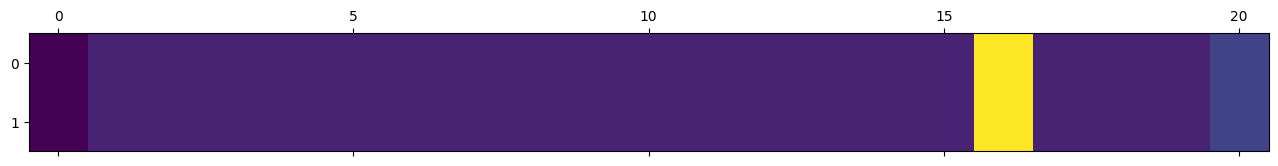

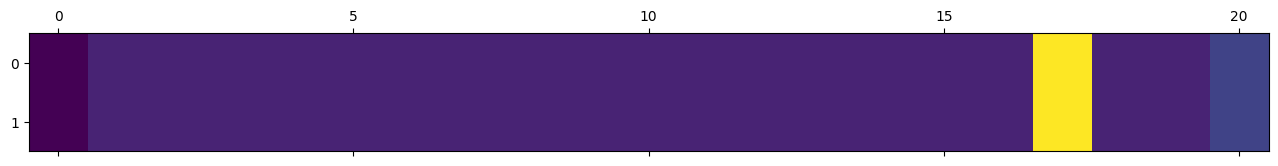

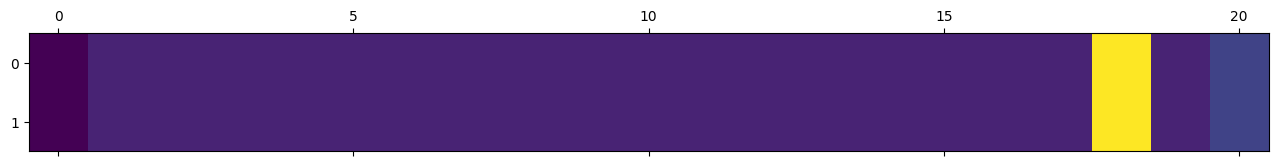

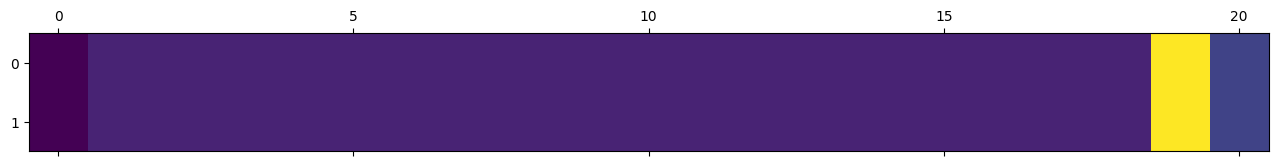

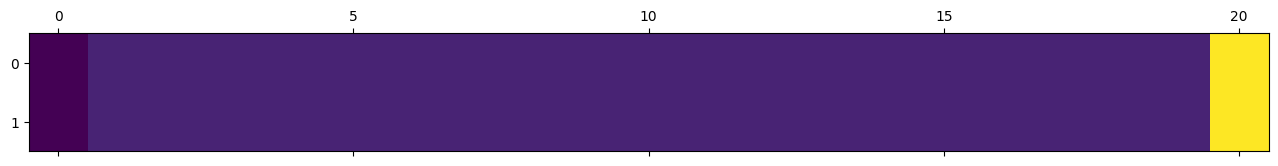

TESTING total timesteps is 11 total rewards is 1


/tmp/ipython-input-6-2232198453.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


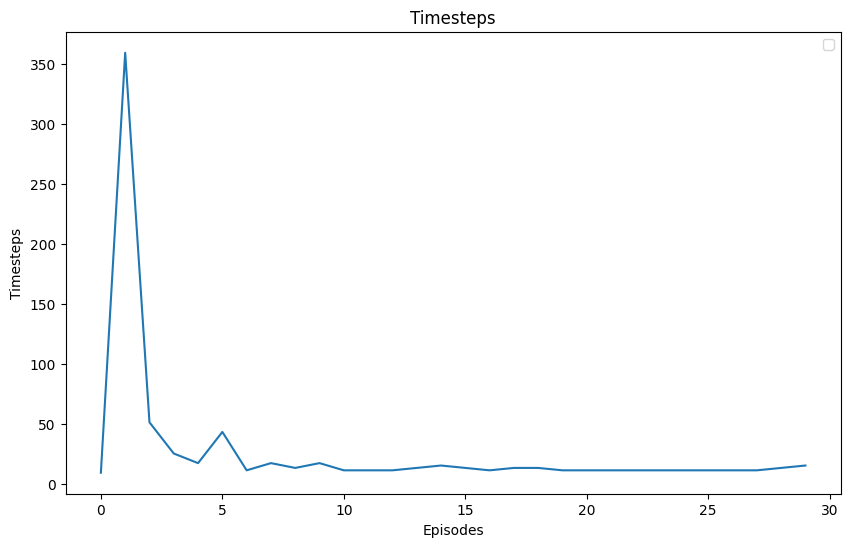

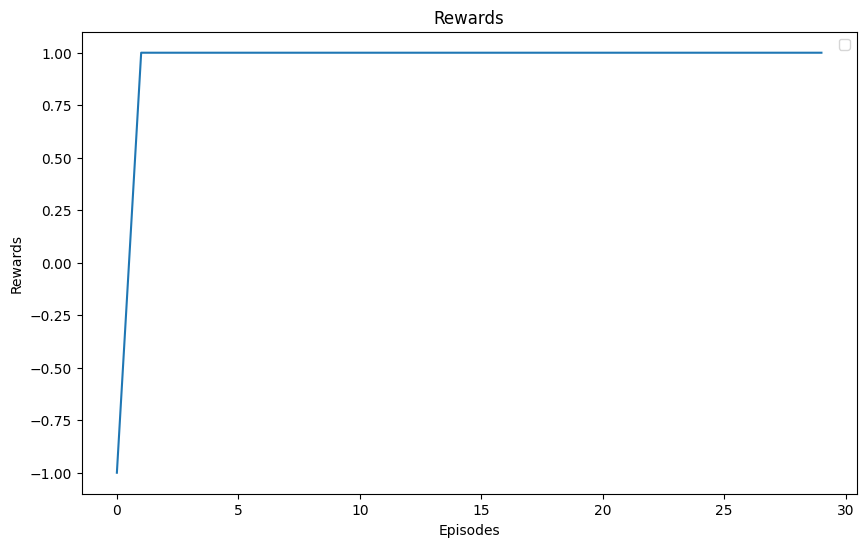

In [ ]:
### TO DO: edit epsilon ###
EPSILON = 0.1
### TO DO: edit number of episodes ###
EPISODES = 30

env = RandomWalkEnvironment(action_space=ACTION_SPACE)
agent = Agent(action_space=ACTION_SPACE, epsilon=EPSILON)

timesteps, rewards = train_agent(agent, env, episodes=EPISODES)
test_agent(agent, env)

plot(timesteps, "Timesteps")
plot(rewards, "Rewards")
